#**Gradient Peturbation on CNNs**#

This notebook investigates a method for finding adversarial examples on image classification tasks. In particular, we use gradient based perturbation attacks, which climb the loss gradient with respect to input images to find adversarial perturbations.

Attacks are based on the [Fast Gradient Sign Method](https://arxiv.org/pdf/1412.6572), introduced by Goodfellow et. al. (2015).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms.transforms import ToTensor
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt

## Setup


We use MNIST's handwritten digit data.

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True) #mini-batch size for training is = 64
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.69MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Next we define a simple CNN architecture

In [3]:
#Defining the CNN

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #the first convolutional block:
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        #the second convolutional block:
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

We define a train and evaluate loop.


In [13]:
def train_model(model, train_dataloader, epochs, optimizer, criterion):

  model.train()
  model.to(device)

  for epoch in range(epochs):
    train_loss_accumulate = 0

    for (data, target) in train_dataloader:
      data = data.to(device)
      target = target.to(device)

      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss_accumulate += loss.item()

  return model


def evaluate_model(model, dataloader, criterion):
  model.eval()
  model.to(device)
  test_accuracy = 0

  for (data, target) in dataloader:
    data = data.to(device)
    target = target.to(device)
    probs = model(data)
    labels_pred = torch.argmax(probs, dim =1)
    comp = (labels_pred == target)
    test_accuracy += torch.sum(comp.float()) / comp.shape[0]

  return (test_accuracy/len(dataloader)).item()

Training this CNN, we can see that without adversarial examples, it's enough to achieve excellent test accuracy (99%) on the relatively simple MNIST data

In [14]:
model = CNN()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.002)

epochs = 4

model = train_model(model, train_dataloader, epochs, optimizer, criterion)

print("accuracy of the trained model on the test data:", evaluate_model(model, test_dataloader, criterion))

accuracy of the trained model on the test data: 0.9901999831199646


## Adversarial gradient attacks

In [15]:
def attack(model, input, label, criterion, epsilon):
  x = input
  x = x.to(device)
  x.requires_grad_(True)

  loss = criterion(model(x),label)

  model.zero_grad()

  loss.backward()

 # here, epsion denotes the stepsize
  x_perturbed = x + epsilon*x.grad.sign()

  return x_perturbed #the perturbed vector is called x_perturbed

The function above defines a very simple adversarial gradient attack on any model. In particular, we take a model, input, label, loss function, and sensitivity epsilon. Assuming that the model is in eval mode (i.e. autograd doesn't apply to it), we calculate the loss with respect to the model prediction and the label, and get the gradient of this loss *with respect to the input*.

Adding a small epsilon vector in the direction of the gradient allows us to find a new input, perturbed by epsilon, which maximizies loss (i.e. may cause the model to misclassify) - that is, an adversarial example.

As we can see below, this can lead to extremely bad test accuracy for our trained model, especialy for larger epsilon.


In [16]:
def test_perturbation_accuracy(model, dataloader, criterion, epsilon):
  model.eval()
  model.to(device)
  adversarial_test_accuracy = 0

  for (data, target) in dataloader:
    data = data.to(device)
    target = target.to(device)
    data_perturbed = attack(model, data, target, criterion, epsilon)
    data_perturbed = data_perturbed.to(device)

    probs = model(data_perturbed)
    labels_pred = torch.argmax(probs, dim =1)
    comp = (labels_pred == target)
    adversarial_test_accuracy += torch.sum(comp.float()) / comp.shape[0]

  return (adversarial_test_accuracy/len(dataloader)).item()

epsilon = 0.05
acc = test_perturbation_accuracy(model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(1) with perturbation radius", epsilon,", the test accuracy over the perturbed data is = ", acc, '\n')

epsilon = 0.1
acc = test_perturbation_accuracy(model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(2) with perturbation radius", epsilon,", the test accuracy over the perturbed data is = ", acc, '\n')

epsilon = 0.2
acc = test_perturbation_accuracy(model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(3) with perturbation radius", epsilon,", the test accuracy over the perturbed data is = ", acc)

(1) with perturbation radius 0.05 , the test accuracy over the perturbed data is =  0.8477999567985535 

(2) with perturbation radius 0.1 , the test accuracy over the perturbed data is =  0.4997999966144562 

(3) with perturbation radius 0.2 , the test accuracy over the perturbed data is =  0.13459999859333038


Let's visualize some of the perturbed images.

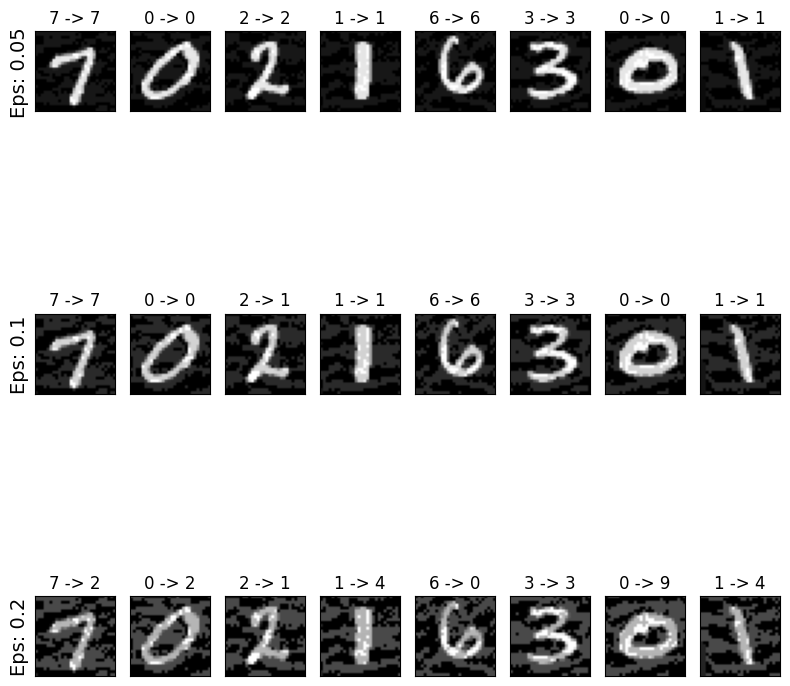

In [17]:
epsilons = [0.05, 0.1, 0.2]
examples = []
accuracies = []


data, target = next(iter(test_dataloader))
data = data.to(device)
target = target.to(device)
# Run test for each epsilon

for eps in epsilons:
    ex = attack(model, data, target, criterion, eps)
    probs = model(ex)
    labels_pred = torch.argmax(probs, dim =1)
    accuracies.append(labels_pred)
    examples.append(ex)

cnt = 0

plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        ex = examples[i][j].cpu().detach().squeeze(0).numpy()
        orig = target[j]
        adv = accuracies[i][j]

        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Training a robust model using adversarial examples


The basic idea is simple. We will need to show adversarial examples at training time so that the model learns that these perturbations exist, and is trained to be robust against them. So in each iteration of the training, weperturb the batch training data (using the function `attack` written above) and use that as the data fed to the model for training. In this way it will learn to be robust.

Here, we use epsilon = 0.1 for our robustness training and evaluate later on other perturbation values. A more rigorous training process could involve randomly sampling epsilon in a continous range (e.g [0,1]) according to some distirbution to introduce the model to various levels of attack

In [18]:
def train_model_adversarial(model, train_dataloader, epochs, optimizer, criterion, epsilon):

  model.train()
  model.to(device)

  for epoch in range(epochs):
    train_loss_accumulate = 0

    for (data, target) in train_dataloader:
      data = data.to(device)
      target = target.to(device)
      optimizer.zero_grad()
      data_perturbed = attack(model, data, target, criterion, epsilon).detach()
      output = model(data_perturbed)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss_accumulate += loss.item()

    print("epoch = ", epoch, " loss = ", train_loss_accumulate/len(train_dataloader))

  return model

cnn_model = CNN()
Model = train_model_adversarial(cnn_model, train_dataloader, 2, optim.Adam(cnn_model.parameters(), lr = 0.002), nn.CrossEntropyLoss(), 0.1)

print("accuracy of the trained model on the test data:", evaluate_model(Model, test_dataloader, nn.CrossEntropyLoss()))



epoch =  0  loss =  0.44988772210313566
epoch =  1  loss =  0.22474502521688178
accuracy of the trained model on the test data: 0.988099992275238


As we can see below, the model is now much more robust, with > 90% accuracy for epsilon less than or equal to our training setting of epsilon = 0.1, whereas our original model dropped to 50% accuracy on the same attacks.

On top of this, even for perturbations larger than our robustness training examples (epsilon=0.2), this new model performs far better: ~75% accuracy compared to just 12% on the original model

In [19]:
epsilon = 0.05
acc = test_perturbation_accuracy(Model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(1) with perturbation radius", epsilon,", the test accuracy over the perturbed data is = ", acc, '\n')

epsilon = 0.1
acc = test_perturbation_accuracy(Model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(2) with perturbation radius", epsilon,", the test accuracy over the perturbed data is = ", acc, '\n')

epsilon = 0.2
acc = test_perturbation_accuracy(Model, test_dataloader, nn.CrossEntropyLoss(), epsilon)
print("(3) with perturbation radius", epsilon,", the test accuracy over the perturbed data is = ", acc)

(1) with perturbation radius 0.05 , the test accuracy over the perturbed data is =  0.9699999690055847 

(2) with perturbation radius 0.1 , the test accuracy over the perturbed data is =  0.9361000061035156 

(3) with perturbation radius 0.2 , the test accuracy over the perturbed data is =  0.7602999806404114
